**Solution on Basic Classification Models**

BAS 474

Charles Liu

In [ ]:
library(regclass)
library(caret)
library(pROC)

The `ACCOUNT` data deals with customers of a bank and whether they have or have not purchased into a new type of CD account offered by the bank (the `Purchase` column, levels are `Yes` and `No`).

In [2]:
data(ACCOUNT)
summary(ACCOUNT)

 Purchase        Tenure      CheckingBalance     SavingBalance   
 No :15899   Min.   : 0.30   Min.   :  -774.83   Min.   :     0  
 Yes: 8343   1st Qu.: 1.90   1st Qu.:    65.08   1st Qu.:     0  
             Median : 3.90   Median :   568.98   Median :     0  
             Mean   : 5.76   Mean   :  2168.01   Mean   :  3127  
             3rd Qu.: 6.70   3rd Qu.:  1817.21   3rd Qu.:  1196  
             Max.   :61.50   Max.   :278093.83   Max.   :700027  
     Income       Homeowner        Age        Area.Classification
 Min.   :  0.00   No :11078   Min.   :16.00   R:6195             
 1st Qu.: 20.00   Yes:13164   1st Qu.:38.00   S:8615             
 Median : 34.00               Median :48.00   U:9432             
 Mean   : 40.33               Mean   :47.95                      
 3rd Qu.: 55.00               3rd Qu.:58.00                      
 Max.   :233.00               Max.   :94.00                      

a.  The `Tenure`, `CheckingBalance`, `SavingBalance`, and `Income` columns are all quite skewed.  Logistic regression models tend to be more effective when predictors are symmetric, so let's replace the values in each column with the `log10` of their values to symmetrize them.  However, we need to be careful:  the smallest values for all but `Tenure` are 0 or negative, and we cannot take the logarithm of that!  Thus, for all but `Tenure` add an appropriate number to the column so that its minimum value is 1 before taking the log.  For example, if the smallest value in a column was -2.6, you'd need to add 3.6 and then take the log, e.g. `log10(x+3.6)`.   Verify you can produce the following sanity check.

In [3]:
ACCOUNT$Tenure <- log10(ACCOUNT$Tenure)
ACCOUNT$CheckingBalance <- log10( ACCOUNT$CheckingBalance + 775.83 )
ACCOUNT$SavingBalance <- log10(ACCOUNT$SavingBalance+1)
ACCOUNT$Income <- log10(ACCOUNT$Income+1)
ACCOUNT[c(1,5,7,9),c(2,3,4,5)]

,Tenure,CheckingBalance,SavingBalance,Income
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.04139269,2.889767,0.0000000,0.602060
5,0.89209460,2.889767,0.0000000,1.041393
7,1.04139269,2.929649,3.5210334,1.113943
9,0.49136169,3.266991,0.3996737,1.230449


b.
Split the data into 70% training and 30% holdout.
What class would the naive model predict for everyone?
What is the naive model's accuracy on the training data and on the holdout sample?

In [4]:
set.seed(2019)
train.rows <- sample(1:nrow(ACCOUNT),0.70*nrow(ACCOUNT))
TRAIN <- ACCOUNT[train.rows,]
HOLDOUT <- ACCOUNT[-train.rows,]
head(TRAIN[,1:5])

summary(TRAIN$Purchase)
mean(TRAIN$Purchase=="No") #on training
mean(HOLDOUT$Purchase=="No") #on holdout

,Purchase,Tenure,CheckingBalance,SavingBalance,Income
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
17689,No,0.5797836,3.046920,1.916875,1.491362
13949,No,1.2479733,2.996192,2.412830,1.079181
19882,No,0.9912261,3.516541,3.208906,1.322219
7749,No,1.0755470,3.104265,3.237702,1.612784
3309,No,1.1238516,3.975150,4.257540,1.698970
2833,No,0.6532125,3.052313,3.451719,1.041393


No   Yes 
11149  5820

[1] 0.6570216

[1] 0.6531005

c.  Although arguments could be made for both metrics, explain why the bank would likely prefer to have models tuned for their AUC instead of Accuracy (if you were the bank, what would you be most interested in using this model for)?

**Response**: The AUC tries to make sure that probabilities are ranked correctly. In a sense, it aims to have the probabilities for the “Yes” class be higher than the probabilities for the “No” class. This way the bank could use the model to select the 500 most likely customers to want to purchase the account.

d.
Define `fitControl` so that the AUC will be computed.
Using `train`, fit the vanilla logistic regression model on `TRAIN`.
Remember to have `method='glm'`, `trControl=fitControl`, and `preProc=c("center", "scale")` in `train` and include the `$results` component of the object created so that the estimated generalization error is printed to the screen.
Remember to ignore the warning `The metric "Accuracy" was not in the result set. ROC will be used instead.` because this is exactly what we wanted!

In [5]:
fitControl <- trainControl(method="cv",number=5,classProbs = TRUE, summaryFunction = twoClassSummary)
set.seed(2019)
LOGREG <- train(Purchase~.,data=TRAIN,method='glm',
                               trControl=fitControl, metric='ROC', preProc=c("center", "scale"))
LOGREG$results

,parameter,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,none,0.6637489,0.901067,0.3159794,0.003308042,0.007705096,0.01197214


e.  Define `glmnetGrid` to be all combinations where `alpha` is along the sequence 0, 0.1, 0.2, ..., 0.9, 1, and `lambda` is 10 raised to the sequence of powers -3, -2.5, -2, ..., -1, -0.5.  Run `train` to audition each of these models (with argument `method='glmnet'`, `tuneGrid=glmnetGrid` together with trControl and preProc as defined earlier), include a `plot` of the object created by `train` to see how the estimated generalization error changes with these two parameters.  Print to the screen the row of the `$results` component of that object that shows the best parameters and the estimated generalzation error.   How many different models did `train` evaluate?

[1] 66  2

,alpha,lambda,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,0,0.3162278,0.6637368,0.9956051,0.02061856,0.003748457,0.00107031,0.0035939


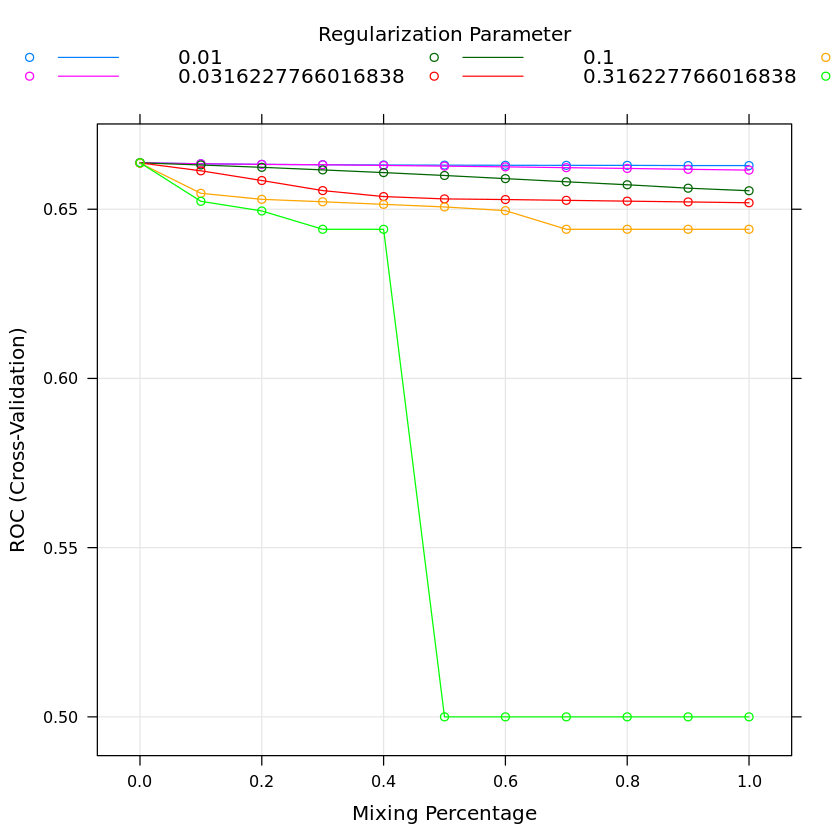

In [6]:
glmnetGrid <- expand.grid(alpha = seq(0,1,.1),lambda = 10^seq(-3,-0.5,by=.5))   
dim(glmnetGrid)
set.seed(2019)
GLMnet <- train(Purchase~.,data=TRAIN,method='glmnet', tuneGrid=glmnetGrid,
                trControl=fitControl, metric='ROC', preProc = c("center", "scale"))

GLMnet$results[rownames(GLMnet$bestTune),]

plot(GLMnet)

f.  Use `train` and audition nearest neighbor models with `k` along the sequence 5, 10, 15, ..., 50, 55, 60.  Include a `plot` of the object created by `train` to see how the estimated generalization error changes with `k`, and print to the screen the row of the `$results` component of that object that shows the best parameters and the estimated generalzation error.  Model fitting may take a minute or so.

The code is already given.

,k,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,55,0.6963405,0.9148798,0.2945017,0.003334817,0.005404554,0.005933435


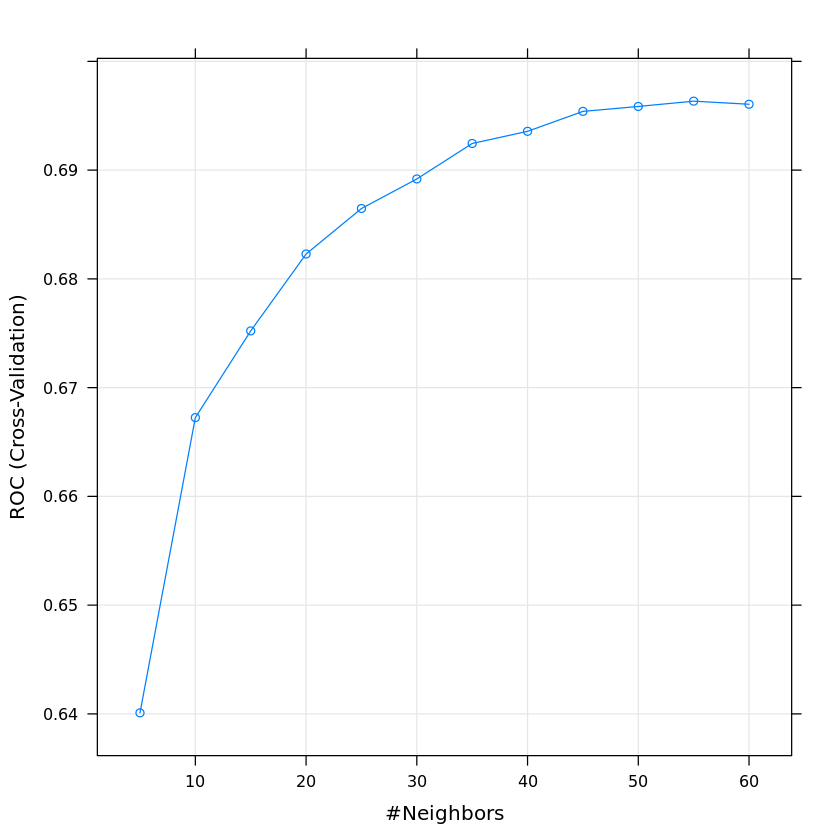

In [7]:
knnGrid <- expand.grid(k= seq(from=5,to=60,by=5) )   
set.seed(2019)
KNN <- train(Purchase~.,data=TRAIN, method='knn', tuneGrid=knnGrid,
                        trControl=fitControl, metric='ROC', preProc = c("center", "scale"))
plot(KNN)
KNN$results[rownames(KNN$bestTune),]  

g.  So what's the verdict?  What model(s) can you eliminate from consideration?  Which model would you select?

**Response**: The nearest neighbor is superior here since it's AUC is more than 1 SD higher than vanilla or regularized regression model. Choose nearest neighbors!

h.
Out of curiosity, let's see how well each of the three models did on the holdout sample using the `roc` command.
Are any of the models overfit (actual AUC about 10% or more less than what was estimated with crossvalidation)?
Remember, the holdout sample only serves as a sanity check to make sure the selected model is not overfit; we do not change our choice of model if a different one did better on the holdout.

The code for KNN is already given. Please modity it for the other two models from parts d and e.

In [8]:
set.seed(2019)
roc(HOLDOUT$Purchase,predict(KNN,newdata=HOLDOUT,type="prob")$Yes, levels=c('No', 'Yes'), direction='<')
roc(HOLDOUT$Purchase,predict(LOGREG,newdata=HOLDOUT,type="prob")$Yes, levels=c('No', 'Yes'), direction='<')
roc(HOLDOUT$Purchase,predict(GLMnet,newdata=HOLDOUT,type="prob")$Yes, levels=c('No', 'Yes'), direction='<')


Call:
roc.default(response = HOLDOUT$Purchase, predictor = predict(KNN,     newdata = HOLDOUT, type = "prob")$Yes, levels = c("No", "Yes"),     direction = "<")

Data: predict(KNN, newdata = HOLDOUT, type = "prob")$Yes in 4750 controls (HOLDOUT$Purchase No) < 2523 cases (HOLDOUT$Purchase Yes).
Area under the curve: 0.6918


Call:
roc.default(response = HOLDOUT$Purchase, predictor = predict(LOGREG,     newdata = HOLDOUT, type = "prob")$Yes, levels = c("No", "Yes"),     direction = "<")

Data: predict(LOGREG, newdata = HOLDOUT, type = "prob")$Yes in 4750 controls (HOLDOUT$Purchase No) < 2523 cases (HOLDOUT$Purchase Yes).
Area under the curve: 0.652


Call:
roc.default(response = HOLDOUT$Purchase, predictor = predict(GLMnet,     newdata = HOLDOUT, type = "prob")$Yes, levels = c("No", "Yes"),     direction = "<")

Data: predict(GLMnet, newdata = HOLDOUT, type = "prob")$Yes in 4750 controls (HOLDOUT$Purchase No) < 2523 cases (HOLDOUT$Purchase Yes).
Area under the curve: 0.651

**Response**: The AUCs on the holdout are a little bit lower, but not by much. Because the AUCs are about what we expected and are not more than 10% lower, we would say that the models are NOT overfit. The nearest neighbor model indeed performed best!